## Processing raw EEG data

+ Prepare EEG 
1. Subtract reference (mastoids)
2. Detrend 
3. Filter
4. Remove bad channels

+ Segment EEG into standard and deviant epochs (ERPs)
1. subtract baseline
2. Reject artefacts
3. Average (for each marker/subject/channel separately)

+ Calculate Mismatch response 
1. deviant - standard for a single subject, for example GiepST_D - GiepST_S
2. check differences between channels and subjects

#### Import Packages 

In [1]:
import matplotlib.pyplot as plt

import mne
import pandas as pd
import numpy as np
import os
import glob
import copy
import sys

import PATH

from functions import display_helper
from functions import dataset_loading
from functions import epodium

#### Load Data

In [3]:
dataset_raw, dataset_filenames = dataset_loading.load_dataset(PATH.ePod_dataset, preload=False)
events = dataset_loading.load_events(PATH.ePod_events, dataset_filenames)
events_12 = epodium.group_events_12(events)

epodium_metadata_filenames = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]  
epod_children, epod_cdi, epod_parents, epod_codes = \
    dataset_loading.load_metadata(PATH.ePod_metadata, epodium_metadata_filenames)

206 EEG files loaded
206 Event Marker files loaded


#### Focus on one participant

In [4]:
index = 44
filename = dataset_filenames[index] + ".bdf"
print(f"Analysing file: {filename}")

path_raw = os.path.join(PATH.ePod_dataset, filename)
raw = mne.io.read_raw_bdf(path_raw, preload = True)

# Set electrodes
raw = raw.pick_channels(epodium.channel_names)
montage = mne.channels.make_standard_montage('standard_1020') 
raw.info.set_montage(montage, on_missing = 'ignore')

# High-pass filter for detrending
raw.filter(0.1, None)
# Create epochs from raw
epochs = mne.Epochs(raw, events_12[index], epodium.event_dictionary, -0.2, 0.8, preload = True)
# Low pass filter for high-frequency artifacts
epochs.filter(None, 40)

Analysing file: 120a.bdf
Extracting EDF parameters from /volume-ceph/ePodium_projectfolder/dataset/120a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3971071  =      0.000 ...  1939.000 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 67585 samples (33.000 sec)

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Setting up low-pass

Number of events,2440
Events,GiepMT_D: 120GiepMT_FS: 130GiepMT_S: 360GiepST_D: 120GiepST_FS: 130GiepST_S: 360GopMT_D: 120GopMT_FS: 130GopMT_S: 360GopST_D: 120GopST_FS: 130GopST_S: 360
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


#### Process ePodium dataset

https://autoreject.github.io/stable/index.html

In [7]:
from autoreject import AutoReject


# for each file in directory

# processed_epochs_from_raw


ar = AutoReject()
epochs_clean = ar.fit_transform(epochs)  


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Dropped 5 epochs: 993, 996, 1053, 1055, 1174


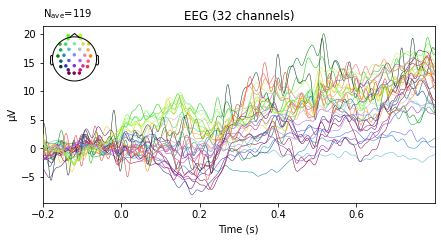

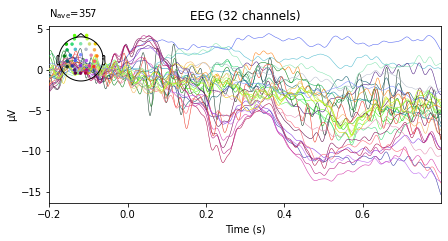

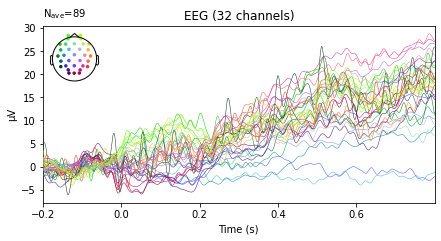

In [8]:
evoked_D = epochs_clean['GiepST_D'].average()
evoked_D.plot(spatial_colors = True)

evoked_S = epochs_clean['GiepST_S'].average()
evoked_S.plot(spatial_colors = True)

mmn = mne.combine_evoked([evoked_D, evoked_S], weights = [1, -1])
fig = mmn.plot(spatial_colors = True)


# for channel in epodium.channel_names:
#     print(channel)


In [15]:
# For each file...
filename_processed = os.path.join(PATH.processed, "ePod_autoreject", "file" + ".npy")
# filename_processed = os.path.join(PATH.ePod_processed_autoreject, "file" + ".npy")
np.save(filename_processed, epochs_clean.get_data())

(2435, 32, 2049)
[[  53143       0       1]
 [  54638       0       1]
 [  56072       0       1]
 ...
 [3956210       0      10]
 [3957664       0      11]
 [3959220       0      11]]
Not setting metadata
2435 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


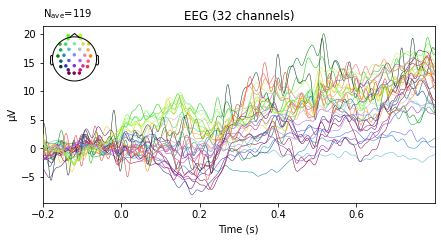

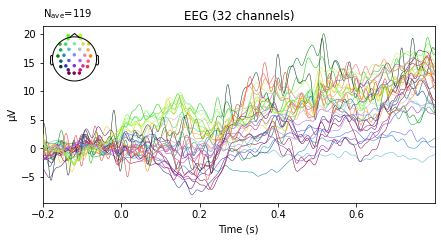

In [30]:
npy = np.load(filename_processed)

print(npy.shape)
print(epochs_clean.events)  

info = mne.create_info(epodium.channel_names, 2048, ch_types='eeg')

back_to_epochs = mne.EpochsArray(npy, info, events=epochs_clean.events, tmin=-0.2, event_id=epodium.event_dictionary)
back_to_epochs.info.set_montage(montage, on_missing = 'ignore')

evoked_D2 = back_to_epochs['GiepST_D'].average()
evoked_D2.plot(spatial_colors = True)

#### Interactive window
Interact with raw EEG data

Using matplotlib as 2D backend.
Opening raw-browser...


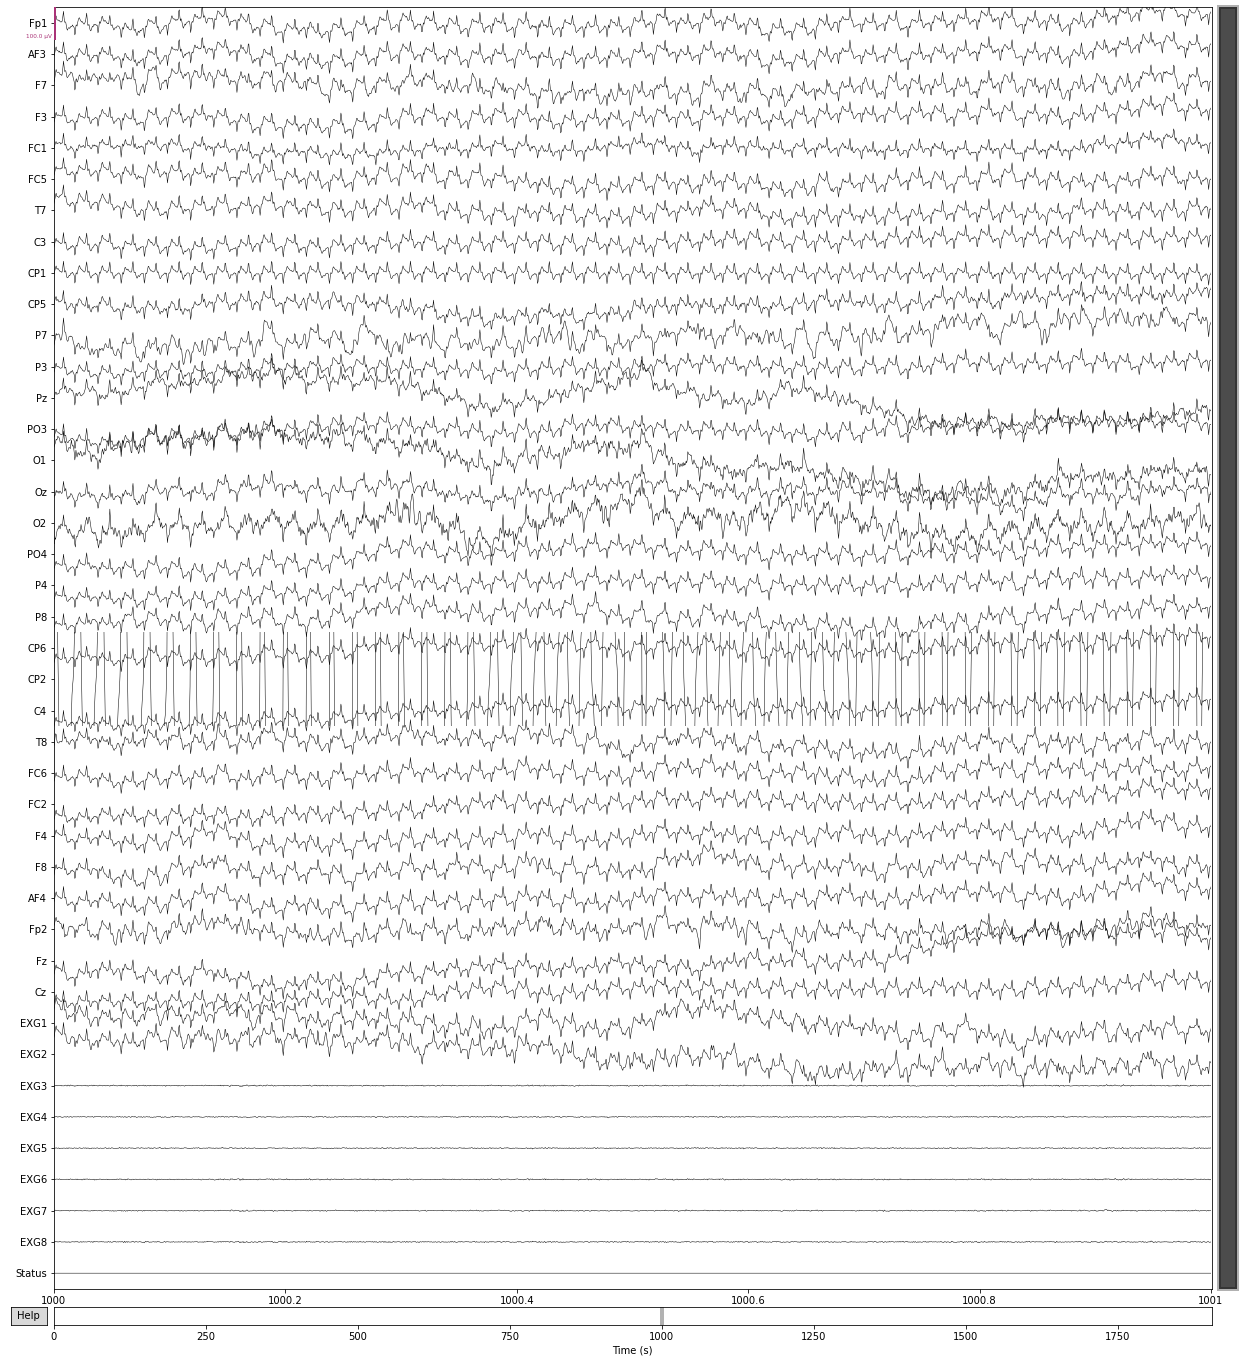

In [4]:
# %matplotlib qt / widget for external/internal interactive window (remove 'fig = ' if no figure shows) (try installing pip install PyQt5 if qt failed due to import binding)
# %matplotlib qt 
fig = mne.viz.plot_raw(epod_raw_preload[participant_index], events[participant_index], n_channels=50, scalings = 50e-6  ,duration = 1, start = 1000)

#### Prepare EEG 

+ Drop unused channels
+ Subtract reference (mastoids) 
+ Detrend 
+ Filter
+ Remove bad channels

epod_raw_preload is used, since some functionalities require preloaded data.


In [5]:
def preprocess_raw(raw):  
    ## Drop unused channels  
    drop_channels = ['EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
    try:
        raw.drop_channels(drop_channels)
    except: print("channels not found")

    ## Subtract reference
    mastoid_channels = ['EXG1', 'EXG2']
    raw = raw.set_eeg_reference(ref_channels=mastoid_channels)

    ## Detrend
    # scipy.signal.detrend

    ## Filter 
    # raw = raw.filter(0.5, 40, fir_design='firwin')

    return raw

epod_raw_filtered = []

for participant_index in range(len(epod_raw_preload)):
    print(f"preprocessing participant {participant_index}")

    epod_raw_filtered.append(preprocess_raw(epod_raw_preload[participant_index])) 

    # Remove bad channels


preprocessing participant 0
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
preprocessing participant 1
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
preprocessing participant 2
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
preprocessing participant 3
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
preprocessing participant 4
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
preprocessing participant 5
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


#### Segment EEG into standard and deviant epochs 
+ subtract baseline
+ Reject artefacts
+ Average to get ERPs (for each subject, event, and channel separately))

#### Calculate Mismatch response 
Deviant minus (-) standard 

Check between subjects to see if the subjects have similar responses

Check between channels to observe which parts of the brain are more influenced by the events


#### Extract features 
+ peak latency
+ peak amplitude
+ mean amplitude


#### Create fitting labels
